### Load libraries

In [25]:
# torch
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import InterpolationMode
import utils.helpers as help

# pytorch lighting
from pytorch_lightning.callbacks import ModelCheckpoint
from lightning_model import BaseCorrModel

# libraries
import matplotlib.pylab as plt
import pandas as pd
from ipywidgets import interactive
import scipy.signal.windows as ssw
from scipy.ndimage.filters import gaussian_filter
from scipy.interpolate import interp1d
from matplotlib.patches import Circle, Rectangle
from matplotlib.path import Path
import matplotlib.path as mpath
import matplotlib.patches as patches
from matplotlib.gridspec import GridSpec
import matplotlib.gridspec as gridspec
from matplotlib import ticker

# networks
from deeplab import DeepLab
import numpy as np

# autocorrelation
from utils.autocorr import autocorr, autocorr_batch

# functions and parameters
f_autocorr = autocorr

# flags
save_fig = True

### Auxiliary functions

In [3]:
def create_circular_mask(h, w, radius=None, center=None):
    """
        Creates a circular mask for a [h,w] image

        Inputs
        ----------
        'h' = int; image height
        'w' = int; image width

        Outputs
        -------
        'inner_mask' = ndarray; mask selecting only the center of the image
        'outer_mask' = ndarray; complementary to center_mask
        """

    if center is None:  # use the middle of the image
        center = (int(w / 2), int(h / 2))
    if radius is None:  # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w - center[0], h - center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0]) ** 2 + (Y - center[1]) ** 2)

    # create masks
    inner_mask = dist_from_center <= radius
    outer_mask = dist_from_center > radius

    return torch.from_numpy(inner_mask), torch.from_numpy(outer_mask)

### Loading check dataset and model checkpoints

In [4]:
# configure dataset
dataset = torchvision.datasets.ImageFolder(
    root="./check_dataset/",
    transform=transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize((128, 256), interpolation=InterpolationMode.BICUBIC),
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5)),
    ]),
)

# instantiate models
DeepFull = DeepLab(1, in_channels=1, pretrained=False, backbone="resnet50")
Deep_r56 =DeepLab(1, in_channels=1, pretrained=False, backbone="resnet50")
Deep_r46 =DeepLab(1, in_channels=1, pretrained=False, backbone="resnet50")
Deep_r36 =DeepLab(1, in_channels=1, pretrained=False, backbone="resnet50")
Deep_r31 =DeepLab(1, in_channels=1, pretrained=False, backbone="resnet50")
Deep_r26 =DeepLab(1, in_channels=1, pretrained=False, backbone="resnet50")

# load checkpoints
DeepFull = BaseCorrModel.load_from_checkpoint(
    "./paper_checkpoints/deeplab50_full_autocorr_reference.ckpt",
    map_location=torch.device("cpu"),
    Network=DeepFull)
Deep_r56 = BaseCorrModel.load_from_checkpoint(
    "./paper_checkpoints/deeplab50_r56_autocorr.ckpt",
    map_location=torch.device("cpu"),
    Network=Deep_r56)
Deep_r46 = BaseCorrModel.load_from_checkpoint(
    "./paper_checkpoints/deeplab50_r46_autocorr.ckpt",
    map_location=torch.device("cpu"),
    Network=Deep_r46)
Deep_r36 = BaseCorrModel.load_from_checkpoint(
    "./paper_checkpoints/deeplab50_r36_autocorr.ckpt",
    map_location=torch.device("cpu"),
    Network=Deep_r36)
Deep_r31 = BaseCorrModel.load_from_checkpoint(
    "./paper_checkpoints/deeplab50_r31_autocorr.ckpt",
    map_location=torch.device("cpu"),
    Network=Deep_r31)
Deep_r26 = BaseCorrModel.load_from_checkpoint(
    "./paper_checkpoints/deeplab50_r26_autocorr.ckpt",
    map_location=torch.device("cpu"),
    Network=Deep_r26)

# models to evaluate status
DeepFull.eval()
Deep_r56.eval()
Deep_r46.eval()
Deep_r36.eval()
Deep_r31.eval()
Deep_r26.eval();

### Loading training data

In [5]:
# deeplab full run
deeplab50_training = pd.read_csv('./paper_data/deeplab50_training.csv')
deeplab50_validation = pd.read_csv('./paper_data/deeplab50_validation.csv')
deeplab50_radius = pd.read_csv('./paper_data/deeplab50_radius.csv')
deeplab50_lr = pd.read_csv('./paper_data/deeplab50_lr.csv')
deeplab50_epoch = pd.read_csv('./paper_data/deeplab50_epoch.csv')
steps_to_epoch = interp1d(deeplab50_epoch['Step'],deeplab50_epoch['Value'],fill_value='extrapolate')


# run comparison
deeplab50_compTraining = pd.read_csv('./paper_data/run-deeplab50_version_4-tag-training_loss.csv',usecols=[1,2])
deeplab50_compValidation = pd.read_csv('./paper_data/run-deeplab50_version_4-tag-val_loss.csv',usecols=[1,2])
enet_compTraining = pd.read_csv('./paper_data/run-enet_version_6-tag-training_loss.csv',usecols=[1,2])
enet_compValidation = pd.read_csv('./paper_data/run-enet_version_6-tag-val_loss.csv',usecols=[1,2])

### Compute reconstruced images and autocorrelations with deep learning

In [8]:
def deepOutput(n_img):

    # imgs, train_labels = next(iter(dataloader))
    imgs = torch.unsqueeze(dataset[n_img][0],0)

    # get image ground truth
    imgGT = imgs[:, :, :, 128:].cpu()

    # get autocorr ground truth
    autocorrGT = imgs[:, :, :, 0:128].cpu()

    # all masks
    inner_mask56, outer_mask56 = create_circular_mask(128, 128, radius=56)
    inner_mask46, outer_mask46 = create_circular_mask(128, 128, radius=46)
    inner_mask36, outer_mask36 = create_circular_mask(128, 128, radius=36)
    inner_mask31, outer_mask31 = create_circular_mask(128, 128, radius=31)
    inner_mask26, outer_mask26 = create_circular_mask(128, 128, radius=26)

    # masked autocorrelations
    autocorrGTmask56 = (autocorrGT + 1.0) * inner_mask56 - 1.0
    autocorrGTmask46 = (autocorrGT + 1.0) * inner_mask46 - 1.0
    autocorrGTmask36 = (autocorrGT + 1.0) * inner_mask36 - 1.0
    autocorrGTmask31 = (autocorrGT + 1.0) * inner_mask31 - 1.0
    autocorrGTmask26 = (autocorrGT + 1.0) * inner_mask26 - 1.0

    # reconstructed images
    imgDeeplabFull = DeepFull(autocorrGT)
    imgDeeplab56 = Deep_r56(autocorrGTmask56)
    imgDeeplab46 = Deep_r46(autocorrGTmask46)
    imgDeeplab36 = Deep_r36(autocorrGTmask36)
    imgDeeplab31 = Deep_r31(autocorrGTmask31)
    imgDeeplab26 = Deep_r26(autocorrGTmask26)

    # reconstructed autocorrelations
    corrDeeplabFull = [f_autocorr(imgDeeplabFull[n,0]+1.0) for n in range(imgDeeplabFull.shape[0])][0]
    corrDeeplab56 = [f_autocorr(imgDeeplab56[n,0]+1.0) for n in range(imgDeeplab56.shape[0])][0]
    corrDeeplab46 = [f_autocorr(imgDeeplab46[n,0]+1.0) for n in range(imgDeeplab46.shape[0])][0]
    corrDeeplab36 = [f_autocorr(imgDeeplab36[n,0]+1.0) for n in range(imgDeeplab36.shape[0])][0]
    corrDeeplab31 = [f_autocorr(imgDeeplab31[n,0]+1.0) for n in range(imgDeeplab31.shape[0])][0]
    corrDeeplab26 = [f_autocorr(imgDeeplab26[n,0]+1.0) for n in range(imgDeeplab26.shape[0])][0]

    out_dict = {'imgGT':imgGT[0,0],
                'autocorrGT':autocorrGT[0,0],
                'autocorrGTmask56':autocorrGTmask56[0,0],
                'autocorrGTmask46':autocorrGTmask46[0,0],
                'autocorrGTmask36':autocorrGTmask36[0,0],
                'autocorrGTmask31':autocorrGTmask31[0,0],
                'autocorrGTmask26':autocorrGTmask26[0,0],
                'imgDeeplabFull':imgDeeplabFull[0,0],
                'imgDeeplab56':imgDeeplab56[0,0],
                'imgDeeplab46':imgDeeplab46[0,0],
                'imgDeeplab36':imgDeeplab36[0,0],
                'imgDeeplab31':imgDeeplab31[0,0],
                'imgDeeplab26':imgDeeplab26[0,0],
                'corrDeeplabFull':corrDeeplabFull,
                'corrDeeplab56':corrDeeplab56,
                'corrDeeplab46':corrDeeplab46,
                'corrDeeplab36':corrDeeplab36,
                'corrDeeplab31':corrDeeplab31,
                'corrDeeplab26':corrDeeplab26,
                }

    return out_dict

In [9]:
# prepare main data
n_img_1=1233
n_img_2=1235
deepOut_1 = deepOutput(n_img_1)
deepOut_2 = deepOutput(n_img_2)

# prepare comparison data
n_img_01 = 347
n_img_02 = 2023
n_img_03 = 5961
n_img_04 = 8376
n_img_05 = 10
n_img_06 = -1
deepOut_01 = deepOutput(n_img_01)
deepOut_02 = deepOutput(n_img_02)
deepOut_03 = deepOutput(n_img_03)
deepOut_04 = deepOutput(n_img_04)
deepOut_05 = deepOutput(n_img_05)
deepOut_06 = deepOutput(n_img_06)

### Compute reconstructed images and autocorrelations with HIO

#### HIO Jacopo auxiliary functions

In [10]:
# preparation function for the traditional phase retrieval algorithms
def prepare_ac(t_ac):
    m_ac = t_ac.detach().numpy()
    m_ac = m_ac - m_ac.min()
    m_ac[m_ac < 1e-10] = 0.0
    mags = np.sqrt(np.abs(np.fft.fft2(m_ac,norm='ortho')))
    return mags

def prepare_img(t_img):
    m_gt = t_img.detach().numpy()
    m_gt = m_gt - m_gt.min()
    m_gt[m_gt < 1e-10] = 0.0
    return m_gt

def hybridIO(guess, mags, beta, n_iter):

    error_list = []
    m_window = np.outer(ssw.tukey(guess.shape[0],0.2),ssw.tukey(guess.shape[0],0.2))
    for n in range(n_iter):

        # compute first error
        error = np.sum( np.abs( mags - np.abs(np.fft.fft2(guess,norm='ortho') ) ) )
        error_list.append(error)

        # compute next iteration of the guess
        g = np.real( np.fft.ifft2( mags * np.exp(1j * np.angle(np.fft.fft2(guess,norm='ortho')) ) ,norm='ortho') )
        mask = - np.clip(np.sign(g), -1,0)
        guess = m_window * gaussian_filter(g * (1 - mask) + mask*(guess - beta*g),0.25)
    
    return error_list, guess

def hybridIOchain(n_iter,mags):
    initial_guess = np.random.default_rng().uniform(size = mags.shape)
    error_list_1, guess = hybridIO(initial_guess,mags,1.5,n_iter)
    error_list_2, guess = hybridIO(guess,mags,1.0,n_iter)
    error_list_3, guess = hybridIO(guess,mags,0.5,n_iter)
    error_list_4, guess = hybridIO(guess,mags,0.0,n_iter)
    error_list = error_list_1 + error_list_2 + error_list_3 + error_list_4
    return error_list, guess

def hybridIOtrial(n_iter,mags,t_img, n_tries=20):

    m_gt = prepare_img(t_img)
    out = [hybridIOchain(n_iter,mags) for _ in range(n_tries)] 
    # find best
    n_best = 0
    error_min = 1.0e20
    for n in range(n_tries):
        error = out[n][0][-1]
        if error < error_min:
            n_best = n
            error_min = error

    img = help.align(out[n_best][1],m_gt)[32:96,32:96]

    return img, out[n_best][0]

#### Compute

In [11]:
# --------------------------------- First image ---------------------------------
# hio image reconstruction
autocorrGT_hio1 = prepare_ac(deepOut_1['autocorrGT'])
autocorrGTmask56_hio1 = prepare_ac(deepOut_1['autocorrGTmask56'])
autocorrGTmask46_hio1 = prepare_ac(deepOut_1['autocorrGTmask46'])
autocorrGTmask36_hio1 = prepare_ac(deepOut_1['autocorrGTmask36'])
autocorrGTmask31_hio1 = prepare_ac(deepOut_1['autocorrGTmask31'])
autocorrGTmask26_hio1 = prepare_ac(deepOut_1['autocorrGTmask26'])
imgDeeplabFull_hio1, errorFull_hio1 = hybridIOtrial(100,autocorrGT_hio1,deepOut_1['imgGT'],n_tries=20)
imgDeeplab56_hio1, error56_hio1 = hybridIOtrial(100,autocorrGTmask56_hio1,deepOut_1['imgGT'],n_tries=20)
imgDeeplab46_hio1, error46_hio1 = hybridIOtrial(100,autocorrGTmask46_hio1,deepOut_1['imgGT'],n_tries=20)
imgDeeplab36_hio1, error36_hio1 = hybridIOtrial(100,autocorrGTmask36_hio1,deepOut_1['imgGT'],n_tries=20)
imgDeeplab31_hio1, error31_hio1 = hybridIOtrial(100,autocorrGTmask31_hio1,deepOut_1['imgGT'],n_tries=20)
imgDeeplab26_hio1, error26_hio1 = hybridIOtrial(100,autocorrGTmask26_hio1,deepOut_1['imgGT'],n_tries=20)

# chio autocorrelation recostruction
corrDeeplabFull_hio1 = f_autocorr(torch.Tensor(imgDeeplabFull_hio1)).numpy()
corrDeeplab56_hio1 = f_autocorr(torch.Tensor(imgDeeplab56_hio1)).numpy()
corrDeeplab46_hio1 = f_autocorr(torch.Tensor(imgDeeplab46_hio1)).numpy()
corrDeeplab36_hio1 = f_autocorr(torch.Tensor(imgDeeplab36_hio1)).numpy()
corrDeeplab31_hio1 = f_autocorr(torch.Tensor(imgDeeplab31_hio1)).numpy()
corrDeeplab26_hio1 = f_autocorr(torch.Tensor(imgDeeplab26_hio1)).numpy()

# --------------------------------- First image ---------------------------------
# hio image reconstruction
autocorrGT_hio2 = prepare_ac(deepOut_2['autocorrGT'])
autocorrGTmask56_hio2 = prepare_ac(deepOut_2['autocorrGTmask56'])
autocorrGTmask46_hio2 = prepare_ac(deepOut_2['autocorrGTmask46'])
autocorrGTmask36_hio2 = prepare_ac(deepOut_2['autocorrGTmask36'])
autocorrGTmask31_hio2 = prepare_ac(deepOut_2['autocorrGTmask31'])
autocorrGTmask26_hio2 = prepare_ac(deepOut_2['autocorrGTmask26'])
imgDeeplabFull_hio2, errorFull_hio2 = hybridIOtrial(100,autocorrGT_hio2,deepOut_2['imgGT'],n_tries=20)
imgDeeplab56_hio2, error56_hio2 = hybridIOtrial(100,autocorrGTmask56_hio2,deepOut_2['imgGT'],n_tries=20)
imgDeeplab46_hio2, error46_hio2 = hybridIOtrial(100,autocorrGTmask46_hio2,deepOut_2['imgGT'],n_tries=20)
imgDeeplab36_hio2, error36_hio2 = hybridIOtrial(100,autocorrGTmask36_hio2,deepOut_2['imgGT'],n_tries=20)
imgDeeplab31_hio2, error31_hio2 = hybridIOtrial(100,autocorrGTmask31_hio2,deepOut_2['imgGT'],n_tries=20)
imgDeeplab26_hio2, error26_hio2 = hybridIOtrial(100,autocorrGTmask26_hio2,deepOut_2['imgGT'],n_tries=20)

# chio autocorrelation recostruction
corrDeeplabFull_hio2 = f_autocorr(torch.Tensor(imgDeeplabFull_hio2)).numpy()
corrDeeplab56_hio2 = f_autocorr(torch.Tensor(imgDeeplab56_hio2)).numpy()
corrDeeplab46_hio2 = f_autocorr(torch.Tensor(imgDeeplab46_hio2)).numpy()
corrDeeplab36_hio2 = f_autocorr(torch.Tensor(imgDeeplab36_hio2)).numpy()
corrDeeplab31_hio2 = f_autocorr(torch.Tensor(imgDeeplab31_hio2)).numpy()
corrDeeplab26_hio2 = f_autocorr(torch.Tensor(imgDeeplab26_hio2)).numpy()

/home/giovi/anaconda3/envs/pytorch_lightning/lib/python3.8/site-packages/skimage/feature/__init__.py:45: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
/home/giovi/anaconda3/envs/pytorch_lightning/lib/python3.8/site-packages/skimage/feature/__init__.py:45: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
/home/giovi/anaconda3/envs/pytorch_lightning/lib/python3.8/site-packages/skimage/feature/__init__.py:45: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
/home/giovi/anaconda3/envs/pytorch_lightning/lib/python3.8/site-packages/skimage/feature/__init__.py:45

### Plots of the training curves

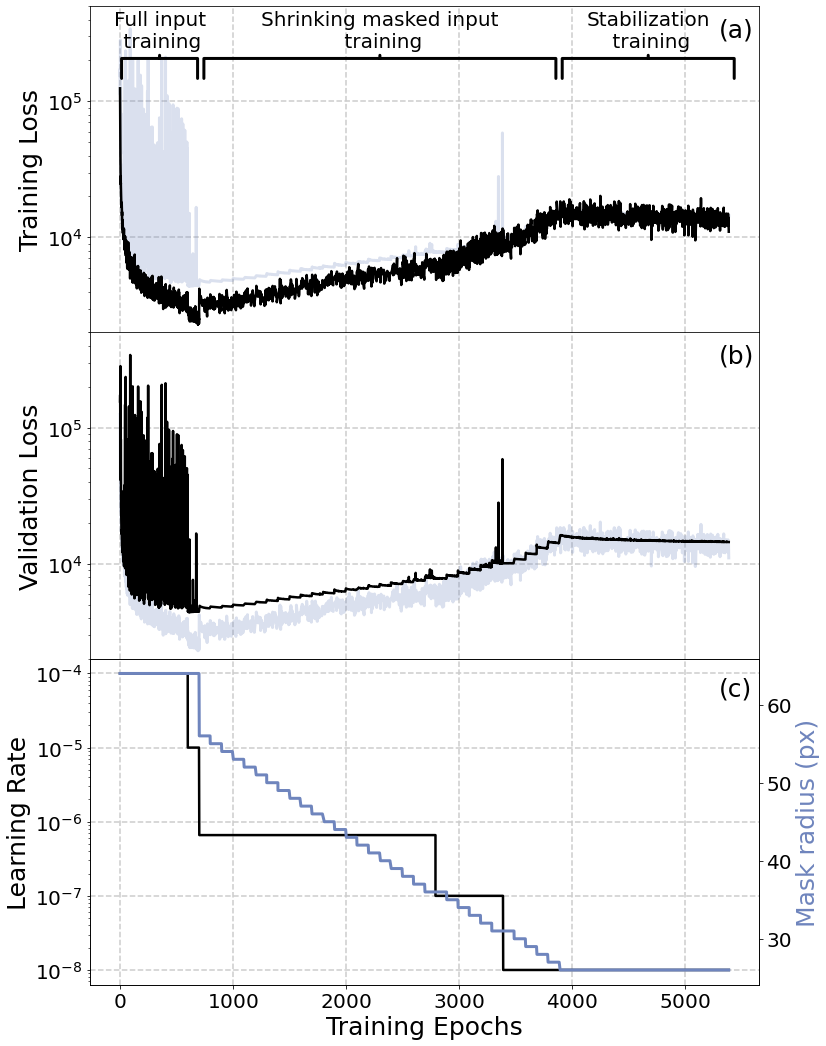

In [26]:
# setup axis
fig = plt.figure(figsize=(12,18))
f_size = 25
gs = fig.add_gridspec(3, hspace=0)
ax = gs.subplots(sharex=True, sharey=False)
lw = 3.0

# ----- plot training loss -----
ax[0].plot(steps_to_epoch(deeplab50_validation['Step']),deeplab50_validation['Value'],color='#6F85BD40',linewidth=lw) 
ax[0].plot(steps_to_epoch(deeplab50_training['Step']),deeplab50_training['Value'], label='Training loss',color='k',linewidth=lw-0.5) 
ax[0].set_yscale('log')
ax[0].set_ylim(2e3,5e5)

# labels
ax[0].set_ylabel('Training Loss', fontsize=f_size)
ax[0].tick_params(labelsize=f_size-5)
ax[0].ticklabel_format(axis='x',style='sci',scilimits=[0,0],useMathText=True)

# standard training annotations
ax[0].annotate('Full input\n training', xy=(350, 2e5),  xycoords='data', fontsize=f_size-5,
                xytext=(350, 2.5e5), textcoords='data',horizontalalignment="center",
                arrowprops=dict(arrowstyle="-[,widthB=1.9,lengthB=1.0",connectionstyle="arc3",linewidth=lw))

# mask shrinking training annotations
ax[0].annotate('Shrinking masked input\n training', xy=(2300, 2e5),  xycoords='data', fontsize=f_size-5,
                xytext=(2300, 2.5e5), textcoords='data',horizontalalignment="center",
                arrowprops=dict(arrowstyle="-[,widthB=8.8,lengthB=1.0",connectionstyle="arc3",linewidth=lw))

# mask shrinking training annotations
ax[0].annotate('Stabilization\n training', xy=(4675, 2e5),  xycoords='data', fontsize=f_size-5,
                xytext=(4675, 2.5e5), textcoords='data',horizontalalignment="center",
                arrowprops=dict(arrowstyle="-[,widthB=4.3,lengthB=1.0",connectionstyle="arc3",linewidth=lw))
ax[0].grid(color='0.8',linewidth=1.5,linestyle='dashed')

# label
ax[0].text(5.3e3,3e5,"(a)",fontsize=f_size)

# ----- plot validation loss -----
ax[1].plot(steps_to_epoch(deeplab50_training['Step']),deeplab50_training['Value'], color='#6F85BD40',linewidth=lw)
ax[1].plot(steps_to_epoch(deeplab50_validation['Step']),deeplab50_validation['Value'], label='Validation loss',color='k',linewidth=lw-0.5) 
ax[1].set_yscale('log')
ax[1].set_ylim(2e3,5e5)

# labels
ax[1].set_ylabel('Validation Loss', fontsize=f_size)
ax[1].tick_params(labelsize=f_size-5)

# grid
ax[1].grid(color='0.8',linewidth=1.5,linestyle='dashed')

# label
ax[1].text(5.3e3,3e5,"(b)",fontsize=f_size)



# ----- plot training schedules loss -----
ax_twin = ax[2].twinx()
ax[2].plot(steps_to_epoch(deeplab50_lr['Step']),deeplab50_lr['Value'], label='Learning rate',color='k',linewidth=lw-0.5) 
ax[2].set_yscale('log')
# ax[2].set_ylim(2e3,5e5)

# labels
ax[2].set_xlabel('Training Epochs', fontsize=f_size)
ax[2].set_ylabel('Learning Rate', fontsize=f_size)
ax[2].tick_params(labelsize=f_size-5)
ax[2].xaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))

# grid
ax[2].grid(color='0.8',linewidth=1.5,linestyle='dashed')

# label
ax[2].text(5.3e3,5e-5,"(c)",fontsize=f_size)



# ----- plot radius shrinking schedule -----
ax_twin.plot(steps_to_epoch(deeplab50_radius['Step']),deeplab50_radius['Value'], label='Mask Radius',color='#6F85BD',linewidth=lw) 
# ax[3].set_yscale('log')
# ax[2].set_ylim(2e3,5e5)

# labels
# ax[3].set_xlabel('Training steps (x10$^6$)', fontsize=f_size)
ax_twin.set_ylabel('Mask radius (px)', fontsize=f_size,color='#6F85BD')
ax_twin.tick_params(labelsize=f_size-5)

# grid
# ax_twin.grid(color='0.8',linewidth=1.5,linestyle='dashed')
if save_fig:
    fig.savefig('./paper_images/fig4_training.svg',bbox_inches='tight')
    fig.savefig('./paper_images/fig4_training.png',bbox_inches='tight',dpi=300)

### Plot results for traditional phase retrieval

In [13]:
# draw circle hole
def make_circle(r,cx,cy):
    t = np.arange(0, np.pi * 2.0, 0.01)
    t = t.reshape((len(t), 1))
    x = cx + r * np.cos(t)
    y = cy + r * np.sin(t)
    return np.hstack((x, y))

# patch auxiliary function
def square_with_hole(r,cx=64,cy=64,x1=-1,x2=129,color='black'):
    x1 = x1
    x2=x2
    square_verts = [
    (x1, x1),  # left, bottom
    (x1, x2),  # left, top
    (x2, x2),  # right, top
    (x2, x1),  # right, bottom
    #    (0, 0),  # ignored
    ]

    square_codes = np.array([
        Path.MOVETO,
        Path.LINETO,
        Path.LINETO,
        Path.LINETO,
        # Path.CLOSEPOLY,
    ],dtype=mpath.Path.code_type)

    circle_verts = make_circle(r,cx,cy)
    circle_codes = np.ones(len(circle_verts), dtype=mpath.Path.code_type) * mpath.Path.LINETO
    circle_codes[0] = mpath.Path.MOVETO

    # draw square with hole
    verts = np.concatenate((square_verts,circle_verts[::1]))
    codes = np.concatenate((square_codes, circle_codes))
    path = Path(verts,codes)
    patch = patches.PathPatch(path, facecolor=color, lw=0, alpha=0.2,edgecolor='k',linestyle="None")
    return patch

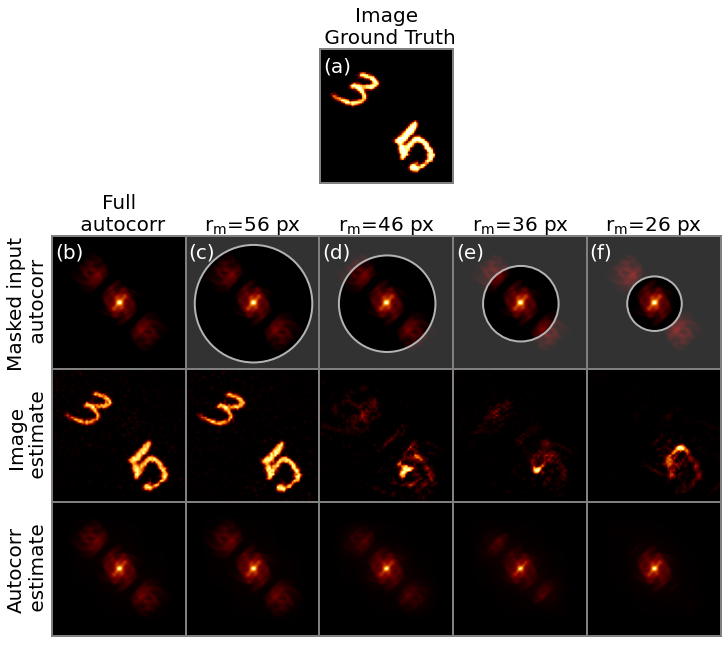

In [27]:
# create figure
fig = plt.figure(figsize = (12,10.8))
r_list = [64,56,46,36,26]
f_size = 25
color = 'white'
cmap = 'afmhot'
label_list = ['(b)','(c)','(d)','(e)','(f)','(g)']

# create nested gridspec for a plot with a regular grid
gsContainer = gridspec.GridSpec(2, 1, figure=fig,height_ratios=(0.25,0.75))
gsTop = gridspec.GridSpecFromSubplotSpec(1, 5, subplot_spec=gsContainer[0],hspace=0.0,wspace=0.0)
gsBottom = gridspec.GridSpecFromSubplotSpec(3, 5, subplot_spec=gsContainer[1],hspace=-0.01,wspace=-0.01)

# create an axis array for the plots
axGT = fig.add_subplot(gsTop[:, 2:3])
nrows = 3
ncols = 5
axs = np.ones(shape=(nrows,ncols),dtype=object)
for i in range(nrows):
    for j in range(ncols):
        axs[i,j] = fig.add_subplot(gsBottom[i,j])

# ----- plotting only imgGT in first row -----
m_gt = deepOut_1['imgGT'][32:96, 32:96].detach().numpy()
axGT.imshow(m_gt, cmap=cmap, vmin=m_gt.min(), vmax=m_gt.max())
axGT.set_title('Image\n Ground Truth', fontsize= f_size-5)
axGT.text(1,10,'(a)',fontsize=f_size-5,color=color)

# format GT axis
axGT.set_xticks([])
axGT.set_yticks([])
for spine in ['bottom','top','right','left']:
    axGT.spines[spine].set_color('gray')
    axGT.spines[spine].set_linewidth(2.0)


# ---------- plot of masked autocorrelations -----------------
title_list = ['Full\n autocorr',
              r'r$_{\mathrm{m}}$=56 px',
              r'r$_{\mathrm{m}}$=46 px',
              r'r$_{\mathrm{m}}$=36 px',
              r'r$_{\mathrm{m}}$=26 px']
for i_r,r in enumerate(r_list):
    axs[0,i_r].imshow(deepOut_1['autocorrGT'].detach().numpy(),cmap=cmap,interpolation='bilinear')
    if i_r >0:
        mask = square_with_hole(r,color=color)
        circle = Circle((64,64),radius=r,fill=False,edgecolor='0.7',linewidth=2.0)
        axs[0,i_r].add_patch(mask)
        axs[0,i_r].add_patch(circle)
    axs[0,i_r].set_title(title_list[i_r], fontsize= f_size-5)
    axs[0,i_r].set_xticks([])
    axs[0,i_r].set_yticks([])
    axs[0,i_r].text(2,20,label_list[i_r],fontsize=f_size-5,color=color)
axs[0,0].set_ylabel('Masked input\n autocorr', fontsize= f_size-5)


# ---------- plot of reconstructed images -----------------
data_list = [
    imgDeeplabFull_hio1,
    imgDeeplab56_hio1,
    imgDeeplab46_hio1,
    imgDeeplab36_hio1,
    imgDeeplab26_hio1,
]
for i_r,r in enumerate(r_list):
    axs[1,i_r].imshow(data_list[i_r],cmap=cmap,interpolation='bilinear')
axs[1,0].set_ylabel('Image\n estimate', fontsize= f_size-5)


# ---------- plot of reconstructed autocorrelations -----------------
data_list = [
    corrDeeplabFull_hio1,
    corrDeeplab56_hio1,
    corrDeeplab46_hio1,
    corrDeeplab36_hio1,
    corrDeeplab26_hio1,
]
for i_r,r in enumerate(r_list):
    axs[2,i_r].imshow(data_list[i_r],cmap=cmap,interpolation='bilinear')
axs[2,0].set_ylabel('Autocorr\n estimate', fontsize= f_size-5)


for i in range(nrows):
    for j in range(ncols):
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])
        for spine in ['bottom','top','right','left']:
            axs[i,j].spines[spine].set_color('gray')
            axs[i,j].spines[spine].set_linewidth(2.0)

if save_fig:
    fig.savefig('./paper_images/fig1_hio.svg',bbox_inches='tight')
    fig.savefig('./paper_images/fig1_hio.png',bbox_inches='tight',dpi=300)

### Plot single images for NN scheme

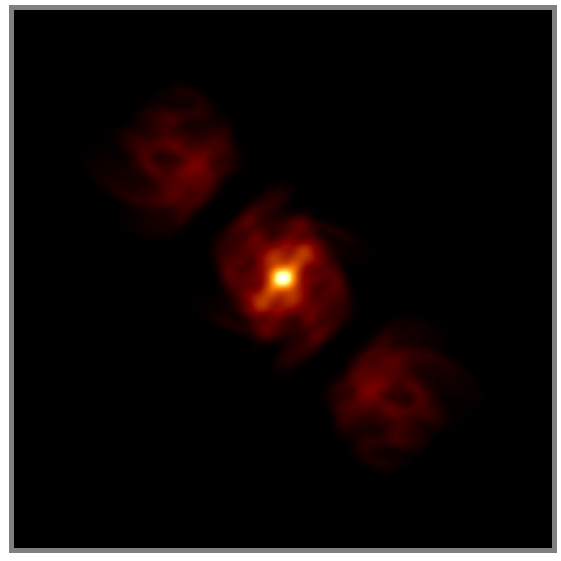

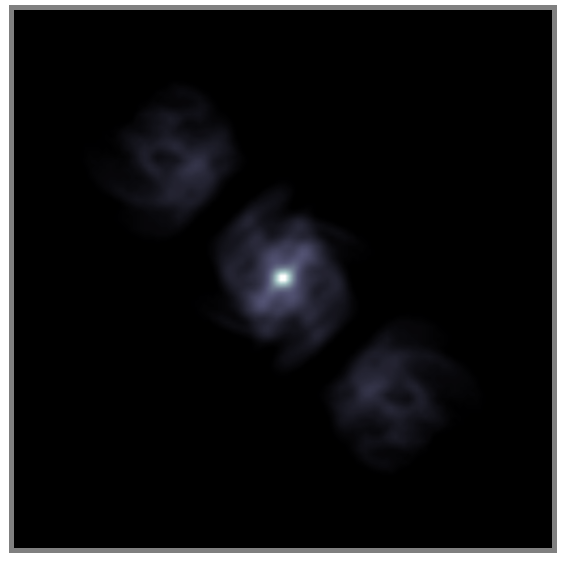

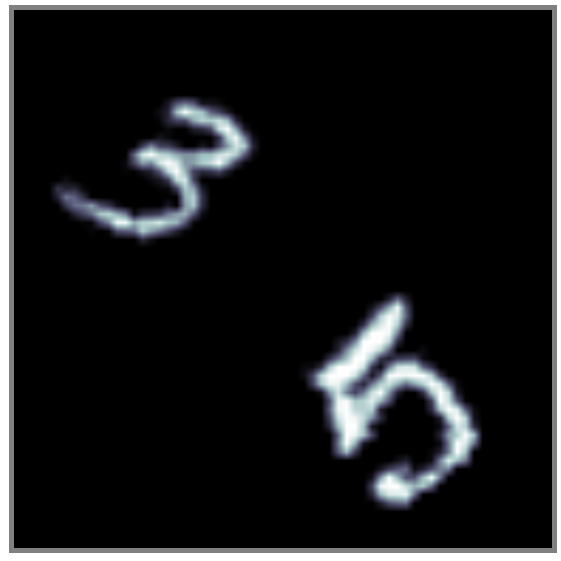

In [28]:
# create figure
color = 'white'
cmap_hot = 'afmhot'
cmap_cold = 'bone'

fig1, ax1 = plt.subplots(figsize=(10,10))
fig2, ax2 = plt.subplots(figsize=(10,10))
fig3, ax3 = plt.subplots(figsize=(10,10))

# get image
m_gt = deepOut_1['imgGT'][32:96, 32:96].detach().numpy()
m_autocorr = deepOut_1['autocorrGT'].detach().numpy()

# format GT axis
ax1.set_xticks([])
ax1.set_yticks([])
ax2.set_xticks([])
ax2.set_yticks([])
ax3.set_xticks([])
ax3.set_yticks([])
for spine in ['bottom','top','right','left']:
    ax1.spines[spine].set_color('gray')
    ax1.spines[spine].set_linewidth(5.0)
    ax2.spines[spine].set_color('gray')
    ax2.spines[spine].set_linewidth(5.0)
    ax3.spines[spine].set_color('gray')
    ax3.spines[spine].set_linewidth(5.0)


# plots
ax1.imshow(m_autocorr,cmap=cmap_hot,interpolation='bilinear',vmax = 1*m_autocorr.max())
ax2.imshow(m_autocorr,cmap=cmap_cold,interpolation='bilinear',vmax = 1*m_autocorr.max())
ax3.imshow(m_gt,cmap=cmap_cold,interpolation='bilinear')

if save_fig:
    fig1.savefig('./paper_images/autocorr_gt_hot.svg',bbox_inches='tight')
    fig2.savefig('./paper_images/autocorr_gt_cold.svg',bbox_inches='tight')
    fig3.savefig('./paper_images/img_gt_cold.svg',bbox_inches='tight')
    fig1.savefig('./paper_images/autocorr_gt_hot.png',bbox_inches='tight',dpi=300)
    fig2.savefig('./paper_images/autocorr_gt_cold.png',bbox_inches='tight',dpi=300)
    fig3.savefig('./paper_images/img_gt_cold.png',bbox_inches='tight',dpi=300)

### Plot samples of the dataset

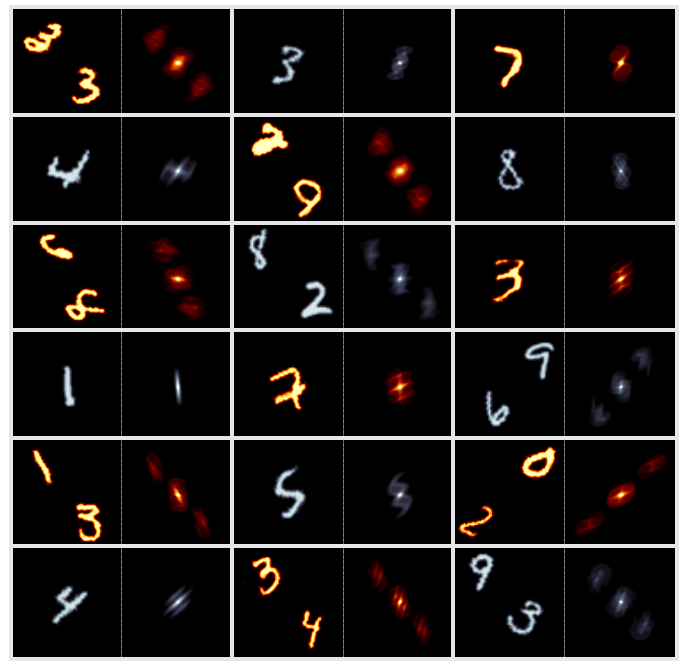

In [29]:
# create figure
fig = plt.figure(figsize = (12,12))
color = 'white'
cmap_odd = 'afmhot'
cmap_even = 'bone'

# create nested gridspec for a plot with a regular grid
nrows = 6
ncols = 6
axesGrid = gridspec.GridSpec(nrows, ncols, figure=fig,hspace=-0.05,wspace=-0.05)

# create an axis array for the plots
axs = np.ones(shape=(nrows,ncols),dtype=object)
for i in range(nrows):
    for j in range(ncols):
        axs[i,j] = fig.add_subplot(axesGrid[i,j])
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])
        if j % 2 ==1:
            for spine in ['bottom','top','right','left']:
                axs[i,j].spines[spine].set_color('0.9')
                axs[i,j].spines[spine].set_linewidth(4.0)
            axs[i,j].spines['left'].set_linewidth(1.0)
            axs[i,j].spines['left'].set_linestyle('dashed')
            axs[i,j].spines['left'].set_color('gray')
        else:
            for spine in ['bottom','top','right','left']:
                axs[i,j].spines[spine].set_color('0.9')
                axs[i,j].spines[spine].set_linewidth(4.0)
            axs[i,j].spines['right'].set_visible(False)

even_list = 2*np.random.randint(0,5000,nrows*ncols//2)
odd_list = 2*np.random.randint(0,4999,nrows*ncols//2) + 1
pick_list = np.array([item for sublist in zip(even_list,odd_list) for item in sublist]).reshape(nrows,ncols)
for i in range(nrows):
    for j in range(ncols//2):
        if (i+j) % 2 ==1:
            cmap = cmap_even
        else:
            cmap = cmap_odd
        img = dataset[pick_list[i,j]][0][0].numpy()[32:96,128+32:-32]
        img_autocorr = dataset[pick_list[i,j]][0][0].numpy()[:,:128]
        axs[i,2*j].imshow(img,cmap=cmap,interpolation='bilinear',vmin=img.min(),vmax=1.25*img.max())
        axs[i,2*j+1].imshow(img_autocorr,cmap=cmap,interpolation='bilinear',vmin=img.min(),vmax=0.75*img.max())
if save_fig:
    fig.savefig('./paper_images/fig2_dataset.svg',bbox_inches='tight')
    fig.savefig('./paper_images/fig2_dataset.png',bbox_inches='tight',dpi=300)


### Plot results for deep learning phase retrieval

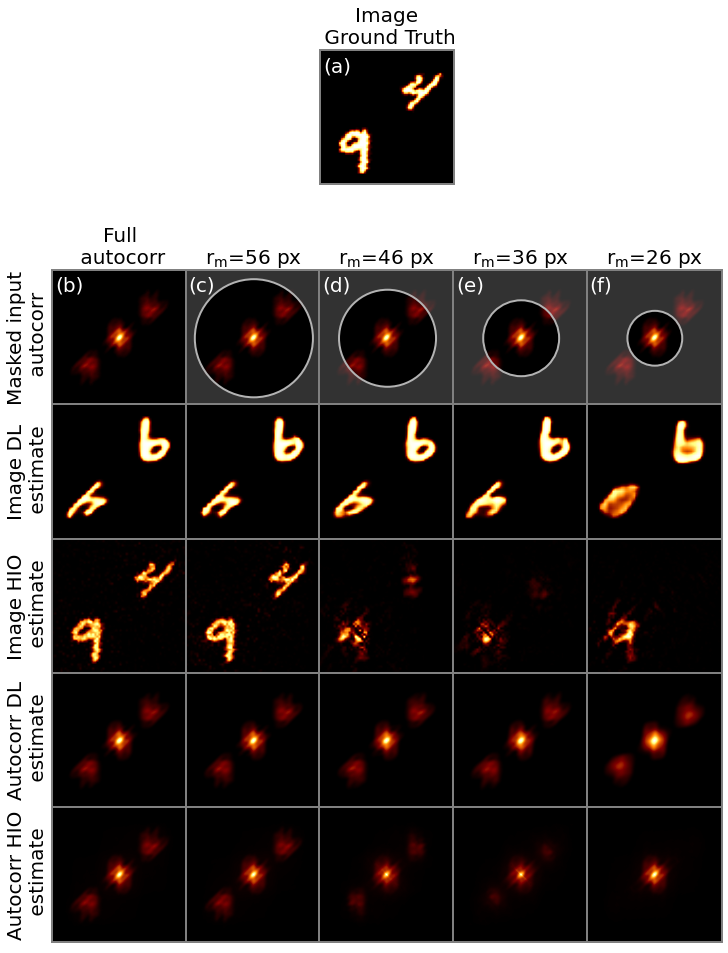

In [30]:
# create figure
fig = plt.figure(figsize = (12,16.5))
r_list = [64,56,46,36,26]
f_size = 25
color = 'white'
cmap = 'afmhot'
label_list = ['(b)','(c)','(d)','(e)','(f)','(g)']

# create nested gridspec for a plot with a regular grid
gsContainer = gridspec.GridSpec(2, 1, figure=fig,height_ratios=(0.175,0.825))
gsTop = gridspec.GridSpecFromSubplotSpec(1, 5, subplot_spec=gsContainer[0],hspace=0.0,wspace=0.0)
gsBottom = gridspec.GridSpecFromSubplotSpec(5, 5, subplot_spec=gsContainer[1],hspace=-0.01,wspace=-0.01)

# create an axis array for the plots
axGT = fig.add_subplot(gsTop[:, 2:3])
nrows = 5
ncols = 5
axs = np.ones(shape=(nrows,ncols),dtype=object)
for i in range(nrows):
    for j in range(ncols):
        axs[i,j] = fig.add_subplot(gsBottom[i,j])

# ----- plotting only imgGT in first row -----
m_gt = deepOut_2['imgGT'][32:96, 32:96].detach().numpy()
axGT.imshow(m_gt, cmap=cmap, vmin=m_gt.min(), vmax=m_gt.max())
axGT.set_title('Image\n Ground Truth', fontsize= f_size-5)
axGT.text(1,10,'(a)',fontsize=f_size-5,color=color)

# format GT axis
axGT.set_xticks([])
axGT.set_yticks([])
for spine in ['bottom','top','right','left']:
    axGT.spines[spine].set_color('gray')
    axGT.spines[spine].set_linewidth(2.0)


# ---------- plot of masked autocorrelations -----------------
title_list = ['Full\n autocorr',
              r'r$_{\mathrm{m}}$=56 px',
              r'r$_{\mathrm{m}}$=46 px',
              r'r$_{\mathrm{m}}$=36 px',
              r'r$_{\mathrm{m}}$=26 px']
for i_r,r in enumerate(r_list):
    axs[0,i_r].imshow(deepOut_2['autocorrGT'].detach().numpy(),cmap=cmap,interpolation='bilinear')
    if i_r >0:
        mask = square_with_hole(r,color=color)
        circle = Circle((64,64),radius=r,fill=False,edgecolor='0.7',linewidth=2.0)
        axs[0,i_r].add_patch(mask)
        axs[0,i_r].add_patch(circle)
    axs[0,i_r].set_title(title_list[i_r], fontsize= f_size-5)
    axs[0,i_r].set_xticks([])
    axs[0,i_r].set_yticks([])
    axs[0,i_r].text(2,20,label_list[i_r],fontsize=f_size-5,color=color)
axs[0,0].set_ylabel('Masked input\n autocorr', fontsize= f_size-5)


# ---------- plot of reconstructed images via deep learning-----------------
data_list = [
    deepOut_2['imgDeeplabFull'].detach().numpy(),
    deepOut_2['imgDeeplab56'].detach().numpy(),
    deepOut_2['imgDeeplab46'].detach().numpy(),
    deepOut_2['imgDeeplab36'].detach().numpy(),
    deepOut_2['imgDeeplab26'].detach().numpy(),
]
for i_r,r in enumerate(r_list):
    axs[1,i_r].imshow(data_list[i_r],cmap=cmap,interpolation='bilinear')
axs[1,0].set_ylabel('Image DL\n estimate', fontsize= f_size-5)


# ---------- plot of reconstructed images via hybrid IO -----------------
data_list = [
    imgDeeplabFull_hio2,
    imgDeeplab56_hio2,
    imgDeeplab46_hio2,
    imgDeeplab36_hio2,
    imgDeeplab26_hio2,
]
for i_r,r in enumerate(r_list):
    axs[2,i_r].imshow(data_list[i_r],cmap=cmap,interpolation='bilinear')
axs[2,0].set_ylabel('Image HIO\n estimate', fontsize= f_size-5)


# ---------- plot of reconstructed autocorrelations via deep learning -----------------
data_list = [
    deepOut_2['corrDeeplabFull'].detach().numpy(),
    deepOut_2['corrDeeplab56'].detach().numpy(),
    deepOut_2['corrDeeplab46'].detach().numpy(),
    deepOut_2['corrDeeplab36'].detach().numpy(),
    deepOut_2['corrDeeplab26'].detach().numpy(),
]
for i_r,r in enumerate(r_list):
    axs[3,i_r].imshow(data_list[i_r],cmap=cmap,interpolation='bilinear')
axs[3,0].set_ylabel('Autocorr DL\n estimate', fontsize= f_size-5)


# ---------- plot of reconstructed autocorrelations via hybrid IO -----------------
data_list = [
    corrDeeplabFull_hio2,
    corrDeeplab56_hio2,
    corrDeeplab46_hio2,
    corrDeeplab36_hio2,
    corrDeeplab26_hio2,
]
for i_r,r in enumerate(r_list):
    axs[4,i_r].imshow(data_list[i_r],cmap=cmap,interpolation='bilinear')
axs[4,0].set_ylabel('Autocorr HIO\n estimate', fontsize= f_size-5)


for i in range(nrows):
    for j in range(ncols):
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])
        for spine in ['bottom','top','right','left']:
            axs[i,j].spines[spine].set_color('gray')
            axs[i,j].spines[spine].set_linewidth(2.0)

if save_fig:
    fig.savefig('./paper_images/fig5_deepLearning.svg',bbox_inches='tight')
    fig.savefig('./paper_images/fig5_deepLearning.png',bbox_inches='tight',dpi=300)

### Plot deep learning phase retrieval sampling

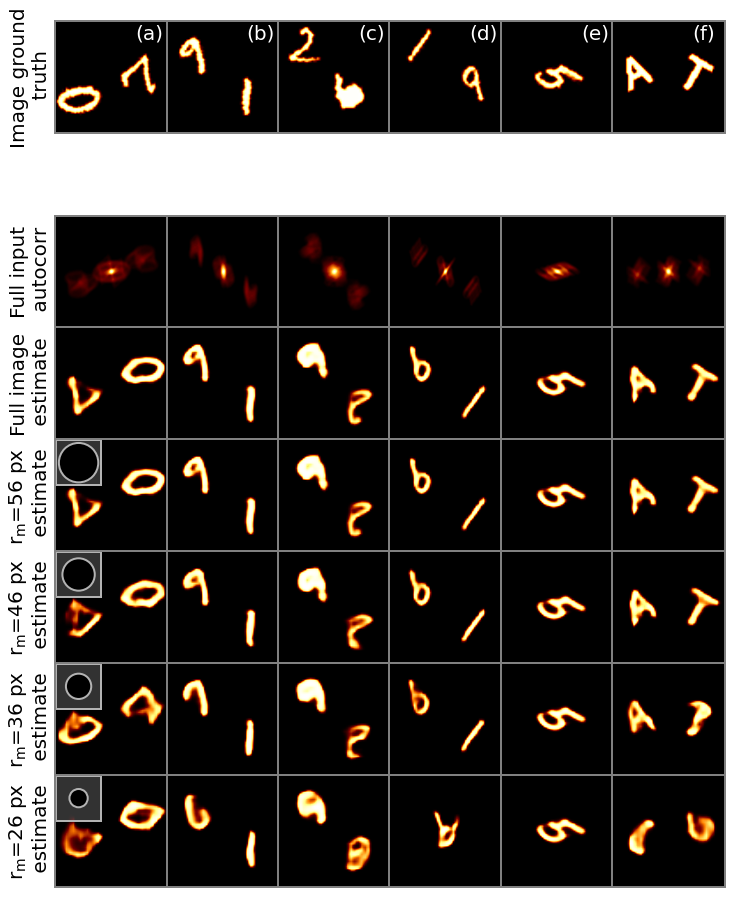

In [31]:
# create figure
fig = plt.figure(figsize = (12,16))
r_list = [64,56,46,36,26]
f_size = 25
color = 'white'
cmap = 'afmhot'
label_list = ['(a)','(b)','(c)','(d)','(e)','(f)','(g)']

# create nested gridspec for a plot with a regular grid
nrows = 6
ncols = 6
gsContainer = gridspec.GridSpec(2, 1, figure=fig,height_ratios=(0.15,0.85))
gsTop = gridspec.GridSpecFromSubplotSpec(1, 6, subplot_spec=gsContainer[0],hspace=-0.01,wspace=-0.01)
gsBottom = gridspec.GridSpecFromSubplotSpec(nrows, ncols, subplot_spec=gsContainer[1],hspace=-0.01,wspace=-0.01)

# create an axis array for the plots
# Top axis array
axTop = np.ones(shape=(1,ncols),dtype=object)
for j in range(ncols):
        axTop[0,j] = fig.add_subplot(gsTop[0,j])
# Bottom axis array
axs = np.ones(shape=(nrows,ncols),dtype=object)
for i in range(nrows):
    for j in range(ncols):
        axs[i,j] = fig.add_subplot(gsBottom[i,j])


# ----- plotting only imgGT in first row -----
data_list = [
    deepOut_01['imgGT'][32:96,32:96].detach().numpy(),
    deepOut_02['imgGT'][32:96,32:96].detach().numpy(),
    deepOut_03['imgGT'][32:96,32:96].detach().numpy(),
    deepOut_04['imgGT'][32:96,32:96].detach().numpy(),
    deepOut_05['imgGT'][32:96,32:96].detach().numpy(),
    deepOut_06['imgGT'][32:96,32:96].detach().numpy(),
]
for i_r,r in enumerate(data_list):
    axTop[0,i_r].imshow(data_list[i_r],cmap=cmap,interpolation='bilinear')
    axTop[0,i_r].text(45,10,label_list[i_r],fontsize=f_size-5,color=color)
axTop[0,0].set_ylabel('Image ground\n truth', fontsize= f_size-5)


# ---------- plot of full autocorrelations -----------------
data_list = [
    deepOut_01['autocorrGT'].detach().numpy(),
    deepOut_02['autocorrGT'].detach().numpy(),
    deepOut_03['autocorrGT'].detach().numpy(),
    deepOut_04['autocorrGT'].detach().numpy(),
    deepOut_05['autocorrGT'].detach().numpy(),
    deepOut_06['autocorrGT'].detach().numpy(),
]
for i_r,r in enumerate(data_list):
    axs[0,i_r].imshow(data_list[i_r],cmap=cmap,interpolation='bilinear')
axs[0,0].set_ylabel('Full input\n autocorr', fontsize= f_size-5)


# ---------- plot of full image estimates-----------------
data_list = [
    deepOut_01['imgDeeplabFull'].detach().numpy(),
    deepOut_02['imgDeeplabFull'].detach().numpy(),
    deepOut_03['imgDeeplabFull'].detach().numpy(),
    deepOut_04['imgDeeplabFull'].detach().numpy(),
    deepOut_05['imgDeeplabFull'].detach().numpy(),
    deepOut_06['imgDeeplabFull'].detach().numpy(),
]
for i_r,r in enumerate(data_list):
    axs[1,i_r].imshow(data_list[i_r],cmap=cmap,interpolation='bilinear')
axs[1,0].set_ylabel('Full image\n estimate', fontsize= f_size-5)


# ---------- plot of masked r=56px estimated images -----------------
data_list = [
    deepOut_01['imgDeeplab56'].detach().numpy(),
    deepOut_02['imgDeeplab56'].detach().numpy(),
    deepOut_03['imgDeeplab56'].detach().numpy(),
    deepOut_04['imgDeeplab56'].detach().numpy(),
    deepOut_05['imgDeeplab56'].detach().numpy(),
    deepOut_06['imgDeeplab56'].detach().numpy(),
]
for i_r,r in enumerate(data_list):
    axs[2,i_r].imshow(data_list[i_r],cmap=cmap,interpolation='bilinear')
    # mask sketch
    sc = 5
    s_o = 128; s_s = s_o/sc
    r_o = 64; r_s = r_o/sc
    r_m = 56; r_ms = r_m/sc
    if i_r==0:
        mask = square_with_hole(r_ms,cx=r_s,cy=r_s,x2=s_s,color=color)
        circle = Circle((r_s,r_s),radius=r_ms,fill=False,edgecolor='0.7',linewidth=2.0)
        square = Rectangle((0,0),width=s_s,height=s_s,fill=False,edgecolor='0.7',linewidth=2.0)
        axs[2,i_r].add_patch(mask)
        axs[2,i_r].add_patch(circle)
        axs[2,i_r].add_patch(square)
axs[2,0].set_ylabel('r$_{\mathrm{m}}$=56 px\n estimate', fontsize= f_size-5)


# ---------- plot of masked r=46px estimated images -----------------
data_list = [
    deepOut_01['imgDeeplab46'].detach().numpy(),
    deepOut_02['imgDeeplab46'].detach().numpy(),
    deepOut_03['imgDeeplab46'].detach().numpy(),
    deepOut_04['imgDeeplab46'].detach().numpy(),
    deepOut_05['imgDeeplab46'].detach().numpy(),
    deepOut_06['imgDeeplab46'].detach().numpy(),
]
for i_r,r in enumerate(data_list):
    axs[3,i_r].imshow(data_list[i_r],cmap=cmap,interpolation='bilinear')
    # mask sketch
    sc = 5
    s_o = 128; s_s = s_o/sc
    r_o = 64; r_s = r_o/sc
    r_m = 46; r_ms = r_m/sc
    if i_r==0:
        mask = square_with_hole(r_ms,cx=r_s,cy=r_s,x2=s_s,color=color)
        circle = Circle((r_s,r_s),radius=r_ms,fill=False,edgecolor='0.7',linewidth=2.0)
        square = Rectangle((0,0),width=s_s,height=s_s,fill=False,edgecolor='0.7',linewidth=2.0)
        axs[3,i_r].add_patch(mask)
        axs[3,i_r].add_patch(circle)
        axs[3,i_r].add_patch(square)
axs[3,0].set_ylabel('r$_{\mathrm{m}}$=46 px\n estimate', fontsize= f_size-5)


# ---------- plot of masked r=36px estimated images -----------------
data_list = [
    deepOut_01['imgDeeplab36'].detach().numpy(),
    deepOut_02['imgDeeplab36'].detach().numpy(),
    deepOut_03['imgDeeplab36'].detach().numpy(),
    deepOut_04['imgDeeplab36'].detach().numpy(),
    deepOut_05['imgDeeplab36'].detach().numpy(),
    deepOut_06['imgDeeplab36'].detach().numpy(),
]
for i_r,r in enumerate(data_list):
    axs[4,i_r].imshow(data_list[i_r],cmap=cmap,interpolation='bilinear')
    # mask sketch
    sc = 5
    s_o = 128; s_s = s_o/sc
    r_o = 64; r_s = r_o/sc
    r_m = 36; r_ms = r_m/sc
    if i_r==0:
        mask = square_with_hole(r_ms,cx=r_s,cy=r_s,x2=s_s,color=color)
        circle = Circle((r_s,r_s),radius=r_ms,fill=False,edgecolor='0.7',linewidth=2.0)
        square = Rectangle((0,0),width=s_s,height=s_s,fill=False,edgecolor='0.7',linewidth=2.0)
        axs[4,i_r].add_patch(mask)
        axs[4,i_r].add_patch(circle)
        axs[4,i_r].add_patch(square)
axs[4,0].set_ylabel('r$_{\mathrm{m}}$=36 px\n estimate', fontsize= f_size-5)

# ---------- plot of masked r=26px estimated images -----------------
data_list = [
    deepOut_01['imgDeeplab26'].detach().numpy(),
    deepOut_02['imgDeeplab26'].detach().numpy(),
    deepOut_03['imgDeeplab26'].detach().numpy(),
    deepOut_04['imgDeeplab26'].detach().numpy(),
    deepOut_05['imgDeeplab26'].detach().numpy(),
    deepOut_06['imgDeeplab26'].detach().numpy(),
]
for i_r,r in enumerate(data_list):
    axs[5,i_r].imshow(data_list[i_r],cmap=cmap,interpolation='bilinear')
    # mask sketch
    sc = 5
    s_o = 128; s_s = s_o/sc
    r_o = 64; r_s = r_o/sc
    r_m = 26; r_ms = r_m/sc
    if i_r==0:
        mask = square_with_hole(r_ms,cx=r_s,cy=r_s,x2=s_s,color=color)
        circle = Circle((r_s,r_s),radius=r_ms,fill=False,edgecolor='0.7',linewidth=2.0)
        square = Rectangle((0,0),width=s_s,height=s_s,fill=False,edgecolor='0.7',linewidth=2.0)
        axs[5,i_r].add_patch(mask)
        axs[5,i_r].add_patch(circle)
        axs[5,i_r].add_patch(square)
axs[5,0].set_ylabel('r$_{\mathrm{m}}$=26 px\n estimate', fontsize= f_size-5)

# clean axis
for j in range(ncols):
    axTop[0,j].set_xticks([])
    axTop[0,j].set_yticks([])
    for spine in ['bottom','top','right','left']:
        axTop[0,j].spines[spine].set_color('gray')
        axTop[0,j].spines[spine].set_linewidth(2.0)

for i in range(nrows):
    for j in range(ncols):
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])
        for spine in ['bottom','top','right','left']:
            axs[i,j].spines[spine].set_color('gray')
            axs[i,j].spines[spine].set_linewidth(2.0)

if save_fig:
    fig.savefig('./paper_images/fig6_deepLearningSampling.svg',bbox_inches='tight')
    fig.savefig('./paper_images/fig6_deepLearningSampling.png',bbox_inches='tight',dpi=300)